# Population protocols for solving majority

The following notebook is supplemental to [this recent paper](https://arxiv.org/abs/2012.15800).
It contains examples that serve to introduce the main ideas behind the time and space optimal majority protocol described more fully in the paper.

In [1]:
from ppsim import Simulation
from dataclasses import dataclass
import dataclasses
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import ipywidgets as widgets

# Simplest protocols for solving majority

## 4 state majority

The majority problem has a simple 4 state solution, which was analyzed [here](https://arxiv.org/abs/1202.1083) and [here](https://arxiv.org/abs/1404.7671). The rule is always correct, by maintaining the invariant #A - #B.

In [2]:
exact_majority = {
    ('A', 'B'): ('a', 'b'),
    ('A', 'b'): ('A', 'a'),
    ('B', 'a'): ('B', 'b')
}

In the worst case, where the initial gap (#A - #B) is constant, this takes $\Theta(n \log n)$ time to reach the stable correct output configuration.

0 time simulated [00:00, ? time simulated/s]

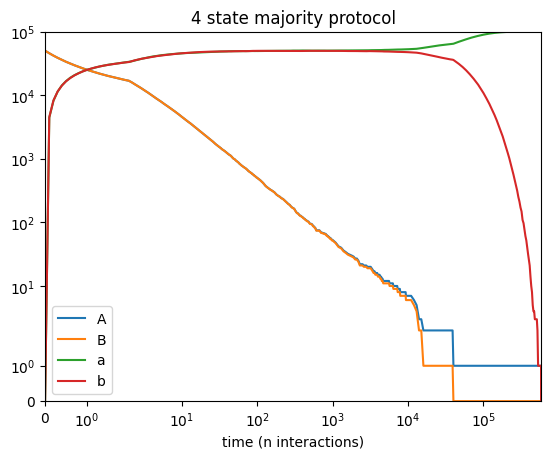

In [3]:
n = 10 ** 5
init_config = {'A': n // 2 + 1, 'B': n // 2}
sim = Simulation(init_config, exact_majority, transition_order='symmetric')
# Setting history_interval to be a function lets the recorded timesteps be evenly spaced on a log plot
sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)
sim.history.plot()
plt.title('4 state majority protocol')
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim(0, sim.times[-1])
plt.ylim(0, n)
plt.show()

## 6 state majority, including tie case

In the case of a tie, the 4 state protocol does not have well-defined behavior. But by adding two more states, we can correct detect ties as well.

A, B  -->  T, T
A, T  -->  A, a
B, T  -->  B, b
B, a  -->  B, b
T, a  -->  T, t
A, b  -->  A, a
T, b  -->  T, t
A, t  -->  A, a
B, t  -->  B, b


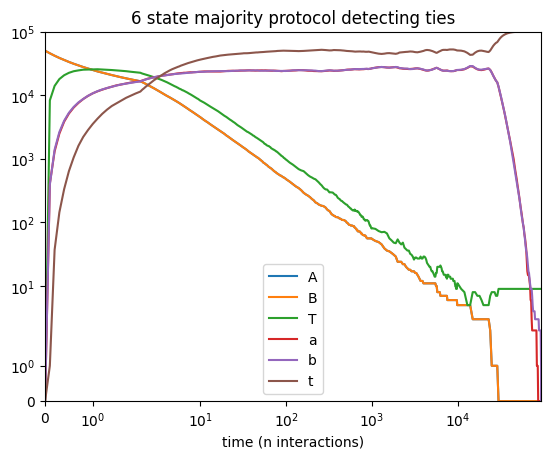

In [4]:
# states are A, B, T, a, b, t
def exact_majority_ties(x, y):
    # Cancellation
    if x == 'A' and y == 'B':
        return ('T', 'T')
    # Active A / B eliminate T
    if x in ['A', 'B'] and y == 'T':
        return (x, x.lower())
    # Active converts passive
    if x.isupper() and y.islower():
        return (x, x.lower())

n = 10 ** 5
sim = Simulation({'A': n // 2, 'B': n // 2}, exact_majority_ties, transition_order='symmetric')
print(sim.reactions)
sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)
sim.history.plot()
plt.title('6 state majority protocol detecting ties')
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlim(0, sim.times[-1])
plt.ylim(0, n)
plt.show()

The full time and space optimal majority protocol will also handle the case of a tie, and it uses this exact 6-state protocol as a stable backup. The agents will switch to running this protocol from their initial inputs if they detect an error that indicates that the fast protocol ran incorrectly. Because this only happens with low probability, using the slow protocol above as a stable backup contributes neglibly to the expected time.

## 3 state approximate majority

Another simple example is the 3-state approximate majority protocol, which was analyzed [here](http://www.cs.yale.edu/homes/aspnes/papers/approximate-majority-journal.pdf) and [here](https://www.cs.ubc.ca/~condon/papers/approx-maj-journal.pdf). This protocol is much faster, but no longer works with probability 1, so does not solve the exact majority problem.

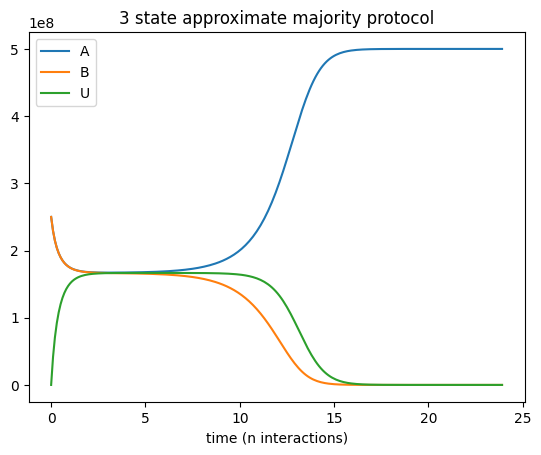

In [5]:
a, b, u = 'A', 'B', 'U'
approximate_majority = {
    (a,b): (u,u),
    (a,u): (a,a),
    (b,u): (b,b)
}
n = 10 ** 9
init_config = {a: n // 2 * 0.5001, b: n // 2 * 0.4999}
sim = Simulation(init_config, approximate_majority)
sim.run(history_interval=0.1)
sim.history.plot()
t = plt.title('3 state approximate majority protocol')

It was shown to stabilize in only $O(\log n)$ time to a consensus configuration. We can provide numerical evidence for this by simulating many trials over a large range of population sizes.

  0%|          | 0/8 [00:00<?, ?it/s]

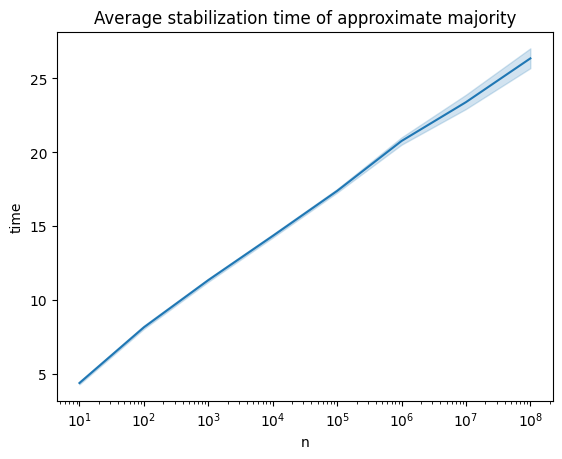

In [6]:
from ppsim import time_trials

ns = [int(n) for n in np.geomspace(10, 10 ** 8, 8)]
def initial_condition(n):
    return {'A': n // 2, 'B': n // 2}
df = time_trials(approximate_majority, ns, initial_condition, num_trials=1000, max_wallclock_time = 30)
fig, ax = plt.subplots()
ax = sns.lineplot(x='n', y='time', data=df)
ax.set_title('Average stabilization time of approximate majority')
ax.set_xscale('log')

This consensus will only be correct with high probability, however, and requires the initial gap to be $\Omega(\sqrt{n \log n})$. We can see that when the gap is close to 0, it is performing essentially a random walk, which is why a sufficiently large initial gap is necessary to ensure the initial majority stays ahead.

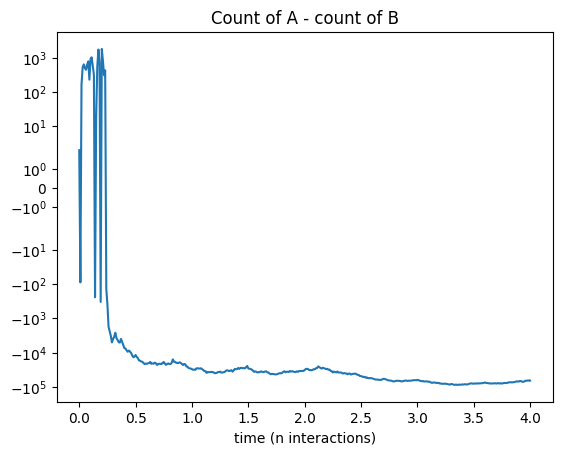

In [7]:
sim.reset({a: n // 2 + 1, b: n // 2 - 1})
sim.run(4, 0.01)
fig, ax = plt.subplots()
ax.set_title('Count of A - count of B')
ax.set_yscale('symlog')
(sim.history['A'] - sim.history['B']).plot()
plt.show()

# Bias Averaging Framework for $O(\log n)$ state protocols

We view the initial states `A` and `B` as having `bias = +1` and `bias = -1` respectively. 
Then the sum $g = \sum_v v.\text{bias}$ gives the gap between opinions, and the majority problem is equivalent to determining $\text{sign}(g)$.
All our rules will maintain $g$ as an invariant to ensure correctness.

To bound the total number of states to $O(\log n)$, the only allowable values for `bias` will be $0,\pm 1, \pm\frac{1}{2}, \pm\frac{1}{4}, \ldots, \pm\frac{1}{2^L}$ where $L = \lceil \log_2(n) \rceil$.
We describe the state of the agent with two fields `opinion`$=\pm 1$ and `exponent`$=0,-1, \ldots, -L$, so `bias = opinion * (2 ** exponent)`.

In [8]:
# This code defines an Agent class that includes these fields, as well as some convenience functions

from fractions import Fraction

@dataclass(unsafe_hash=True)
class Agent:
    opinion: int = 0
    exponent: int = 0
    
    # Lets the protocol directly reference bias, which is inferred from the two data fields of the agent
    @property
    def bias(self):
        return self.opinion * 2 ** self.exponent
    
    # Lets the protocol directly set the value of bias
    @bias.setter
    def bias(self, value):
        if value == 0:
            self.opinion = self.exponent = 0
        else:
            self.opinion = int(np.sign(value))
            exponent = np.log2(abs(value))
            if exponent.is_integer():
                self.exponent = int(exponent)
            else:
                raise ValueError(f'bias = {value} must an integer power of 2')
    
    # Adding a custom string method to print(Agent) displays the bias
    def __str__(self):
        if self.bias == 0:
            return '0'
        s = ''
        if self.bias > 0:
            s += '+'
        if abs(self.bias) > 1/100:
            s += str(Fraction(self.bias))
        else:
            if self.bias < 0:
                s += '-'
            s += '1/2^' + str(abs(self.exponent))
        return s
    
def init_agents(a, b):
    return {Agent(opinion = 1): a, Agent(opinion = -1): b}

The biases change through cancel reactions of the form $+\frac{1}{2^i},-\frac{1}{2^i}\rightarrow 0, 0$ and split reactions of the form $\pm\frac{1}{2^i}, 0 \rightarrow \pm\frac{1}{2^i+1}, \pm\frac{1}{2^i+1}$. These both preserve the invariant sum of the biases, and result in both agents taking the average of the two biases. Thus, these rules can be thought of as an approximation to the averaging rule $i, j \rightarrow \frac{i + j}{2}, \frac{i + j}{2}$, where we are only allowing the transitions that keep the values of bias in $0,\pm 1, \pm\frac{1}{2}, \pm\frac{1}{4}, \ldots, \pm\frac{1}{2^L}$.

In [9]:
def cancel_split(a: Agent, b: Agent, L: int):
     # cancel reaction
    if a.bias == -b.bias:
        a.opinion = b.opinion = 0
        a.exponent = b.exponent = 0
    
    # split reaction
    if a.bias == 0 and abs(b.bias) > 2 ** (-L):
        a.opinion = b.opinion
        a.exponent = b.exponent = b.exponent - 1
    # By default, the protocol is assumed to be symmetric
    # This function returns None in the reversed case where b.bias == 0 and a.bias != 0.
    # In that case, the simulator will automatically switch the order of a and b,
    #  assuming they will have the same non-null interaction in either order.

# To check that the function is working as intended, we can print all reactions for a small instance
print(Simulation(init_agents(1, 1), cancel_split, L = 4).reactions)

    0,    +1  -->   +1/2,  +1/2
    0,  +1/2  -->   +1/4,  +1/4
    0,  +1/4  -->   +1/8,  +1/8
    0,  +1/8  -->  +1/16, +1/16
    0,    -1  -->   -1/2,  -1/2
   +1,    -1  -->      0,     0
    0,  -1/2  -->   -1/4,  -1/4
 +1/2,  -1/2  -->      0,     0
    0,  -1/4  -->   -1/8,  -1/8
 +1/4,  -1/4  -->      0,     0
    0,  -1/8  -->  -1/16, -1/16
 +1/8,  -1/8  -->      0,     0
+1/16, -1/16  -->      0,     0


By themselves, however, these cancel and split reactions do not solve majority.

In [10]:
n = 10 ** 9
## This code ran a simulation and saved it to pickle
# sim = Simulation(init_agents(n // 2 + 1, n // 2), cancel_split, L=int(np.log2(n)))
# sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)
# pickle.dump(sim, open( "majority_simulations/cancel_split.p", "wb" ) )

# # This will load results back from pickle
sim = pickle.load( open( "majority_simulations/cancel_split.p", "rb" ) )

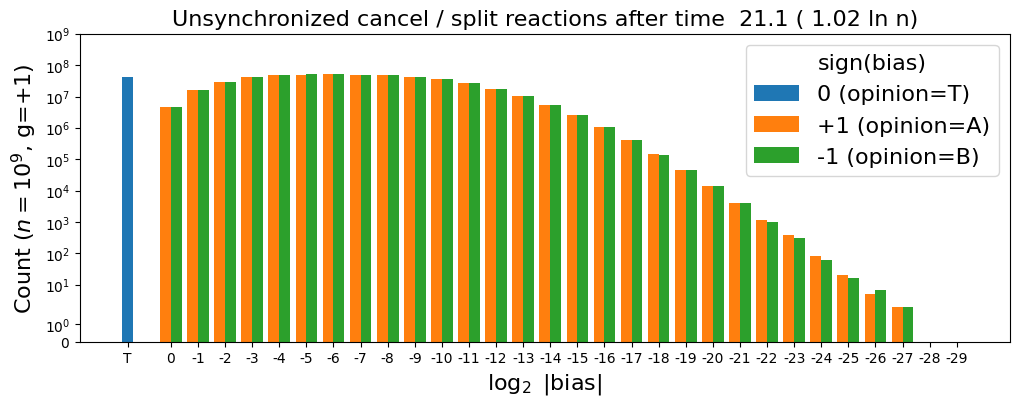

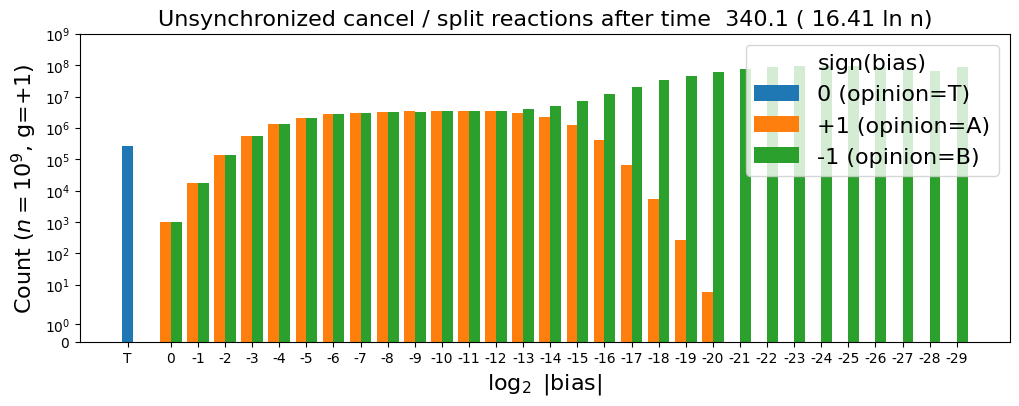

In [11]:
# With a much larger number of states, trying to directly plot sim.history would be messy.
# Instead, we create a barplot which visualizes a single configuration, with a slider that
#   ranges over all times recorded by the simulation.

def plot_config(index):
    fig, ax = plt.subplots(figsize=(12,4))
    snap = sim.history.iloc[index]
    ind = np.arange(len(snap[1].index))
    width = 0.4
    ax.bar(-1, snap[0], width, label='0 (opinion=T)')
    ax.bar(ind + width, snap[1], width, label= '+1 (opinion=A)')
    ax.bar(ind + 2 * width, snap[-1], width, label= '-1 (opinion=B)')
    ax.set_xticks([-1] + list(ind+1.5*width))
    ax.set_xticklabels(['T'] + [str(i) for i in range(0,-len(snap[1]),-1)], fontsize = 10)
    ax.set_xlabel('$\log_2$ |bias|', fontsize=16)
    ax.set_ylabel(f'Count ($n=10^{int(np.log10(n))}$, g=+1)', fontsize=16)
    ax.set_yscale('symlog')
    ax.set_ylim(0, n)
    ax.legend(title = 'sign(bias)', fontsize=16, title_fontsize=16)
    t = sim.times[index]
    ax.set_title(f'Unsynchronized cancel / split reactions after time {t: 0.1f} ({t / np.log(n): 0.2f} ln n)', fontsize=16)
#     fig.savefig('majority_simulations/cancel_split_no_sync2.pdf')
    
# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(112)
plot_config(215)

All values of bias are produced rapidly. When the counts of all bias values are roughly equal, the chance of a cancel reaction drops to $\Theta(\frac{1}{\log n})$. This low rate of cancellation results in a small count of $0$ agents, which then drops the rate of split reactions.

Not only is this protocol slow, it is also not ensured the majority opinion will take over. In this example, the minority opinion B (negative bias) happened to have more split reactions, which resulted in a much larger count of minority agents at smaller bias values. From around time 200 all the way until the protocol becomes silent in $\Theta(n)$ time, there are a larger number of agents with the minority opinion. The majority opinion A agents have a larger bias, but a smaller count.

## Additional bias-preserving transitions

There are a few additional transitions that will also preserve the bias.

In [12]:
from itertools import product

def bias_average(a, b, L):
    a, b = dataclasses.replace(a), dataclasses.replace(b)
    
    # all allowable bias values
    biases = [0] + [2 ** i for i in range(-L,1)] + [-2 ** i for i in range(-L, 1)]
    # all pairs of bias values that preserve the sum
    legal_outputs = [(x,y) for (x,y) in product(biases, biases) if x + y == a.bias + b.bias]
    # choose the pair of bias values which are closest together
    a.bias, b.bias = legal_outputs[np.argmin(np.array([abs(x-y) for (x,y) in legal_outputs]))]
    
    return a, b

# Note that the function above is very inefficient. This will only affect the time it takes the
#   simulator to instantiate the example. After that point, the simulator uses a more efficient
#   internal representation of the transition rule, so it does not matter if the python function
#   that defines the transition rule is efficient.

print(Simulation(init_agents(1, 1), bias_average, L = 4).reactions)

    0,    +1  -->   +1/2,  +1/2
    0,  +1/2  -->   +1/4,  +1/4
    0,  +1/4  -->   +1/8,  +1/8
    0,  +1/8  -->  +1/16, +1/16
    0,    -1  -->   -1/2,  -1/2
   +1,    -1  -->      0,     0
 +1/2,    -1  -->   -1/4,  -1/4
 +1/4,    -1  -->   -1/2,  -1/4
    0,  -1/2  -->   -1/4,  -1/4
   +1,  -1/2  -->   +1/4,  +1/4
 +1/2,  -1/2  -->      0,     0
 +1/4,  -1/2  -->   -1/8,  -1/8
 +1/8,  -1/2  -->   -1/4,  -1/8
    0,  -1/4  -->   -1/8,  -1/8
   +1,  -1/4  -->   +1/2,  +1/4
 +1/2,  -1/4  -->   +1/8,  +1/8
 +1/4,  -1/4  -->      0,     0
 +1/8,  -1/4  -->  -1/16, -1/16
+1/16,  -1/4  -->   -1/8, -1/16
    0,  -1/8  -->  -1/16, -1/16
 +1/2,  -1/8  -->   +1/4,  +1/8
 +1/4,  -1/8  -->  +1/16, +1/16
 +1/8,  -1/8  -->      0,     0
+1/16,  -1/8  -->      0, -1/16
 +1/4, -1/16  -->   +1/8, +1/16
 +1/8, -1/16  -->      0, +1/16
+1/16, -1/16  -->      0,     0


These transitions help eliminate opposite biases, but do not fundamentally change the way the protocol works, and will not get rid of the fundamental flaws.

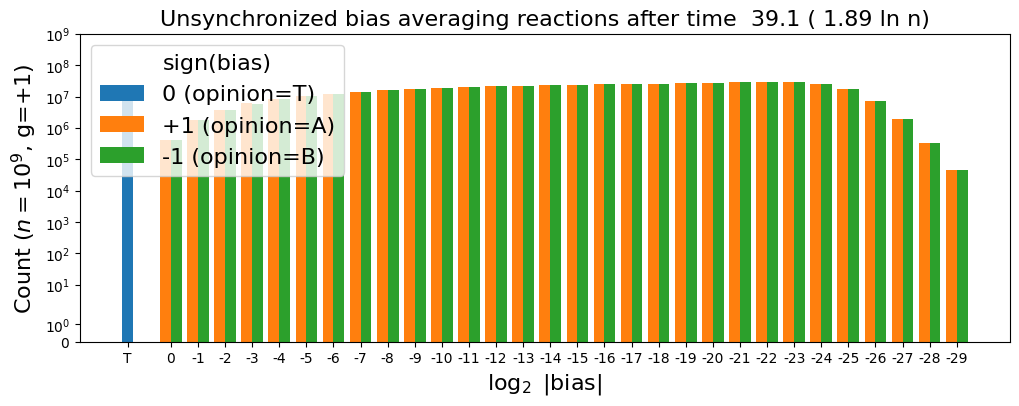

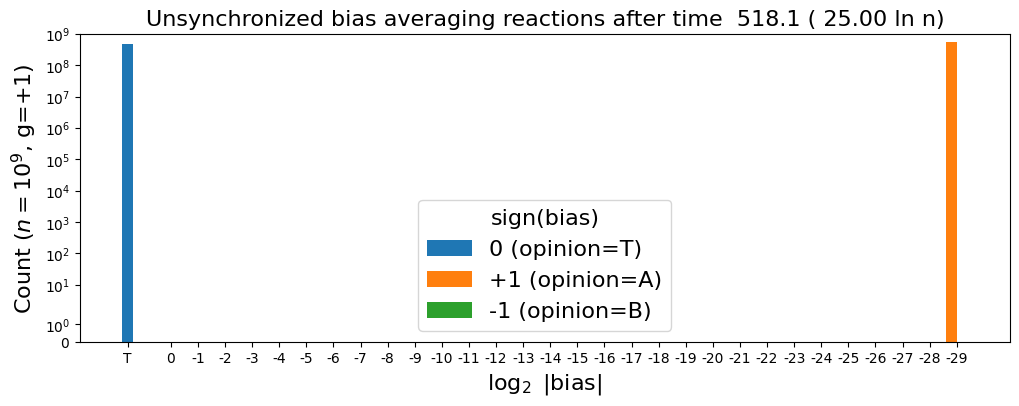

In [13]:
# # This will load results back from pickle
sim = pickle.load( open( "majority_simulations/bias_average.p", "rb" ) )
n = 10 ** 9
g = 1

def plot_config(index):
    fig, ax = plt.subplots(figsize=(12,4))
    snap = sim.history.iloc[index]
    ind = np.arange(len(snap[1].index))
    width = 0.4
    ax.bar(-1, snap[0], width, label='0 (opinion=T)')
    ax.bar(ind + width, snap[1], width, label= '+1 (opinion=A)')
    ax.bar(ind + 2 * width, snap[-1], width, label= '-1 (opinion=B)')
    ax.set_xticks([-1] + list(ind+1.5*width))
    ax.set_xticklabels(['T'] + [str(i) for i in range(0,-len(snap[1]),-1)], fontsize = 10)
    ax.set_xlabel('$\log_2$ |bias|', fontsize=16)
    ax.set_ylabel(f'Count ($n=10^{int(np.log10(n))}$, g=+{g})', fontsize=16)
    ax.set_yscale('symlog')
    ax.set_ylim(0, n)
    ax.legend(title = 'sign(bias)', fontsize=16, title_fontsize=16)
    t = sim.times[index]
    ax.set_title(f'Unsynchronized bias averaging reactions after time {t: 0.1f} ({t / np.log(n): 0.2f} ln n)', fontsize=16)

# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(130)
plot_config(-1)

In some cases, such as the trial shown above, we do successfully eliminate all minority agents. Note, however, that because the rate of cancel reactions is $\Theta(\frac{1}{\log n})$, we expect a fraction $\frac{1}{\log n}$ of $0$ agents. Then means an agents has a $\Theta(\frac{1}{\log n})$ probability of having a split reaction, so it should take $\Theta(\log^2 n)$ time for all agents to split down across all $\Theta(\log n)$ bias values. So even if this protocol was reliable, it would not be faster than existing majority protocols.

Even worse, however, is there is still a possibility of error, as shown in the example below.

In [14]:
## This code ran simulations until finding one that failed to stabilize correctly, and saved the example to pickle
# n = 10 ** 6
# correct = True
# sim = Simulation(init_agents(n // 2 + 1, n // 2), bias_average, L=int(np.log2(n)))
# while correct:
#     sim.reset(init_agents(n // 2 + 1, n // 2))
#     sim.run(history_interval=lambda t: 10 ** len(str(int(t))) / 100)
#     plot_config(-1)
#     plt.show()
#     for agent in sim.config_dict:
#         if agent.opinion == -1:
#             correct = False
# pickle.dump(sim, open( "majority_simulations/bias_average2.p", "wb" ) )

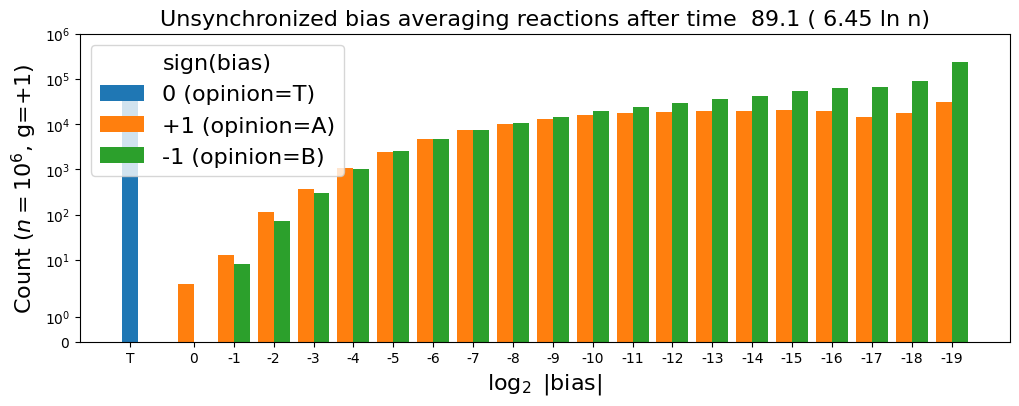

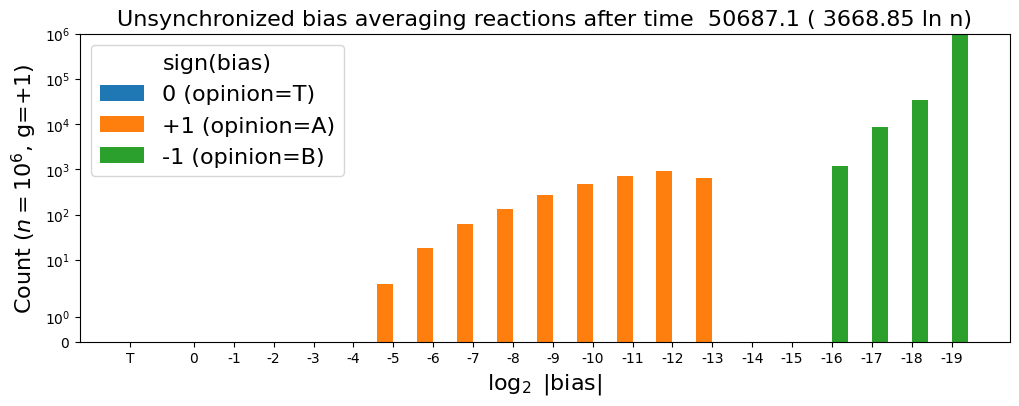

In [15]:
# # This will load results back from pickle
n = 10 ** 6
g = 1
sim = pickle.load( open( "majority_simulations/bias_average2.p", "rb" ) )

# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(180)
plot_config(-1)

In this example, we again have the minority opinion having more split reactions, so the count of the initial minority becomes much larger. When the protocol eventually becomes silent, most agents have the minority opinion, with the smaller count of majority agents having a much larger bias.
Notice that the generalized bias average rules let any values of $\log_2|\text{bias}|$ within distance 2 cancel, so now there is a gap between remaining bias values.

# Adding Synchronization

The key idea to address the issues shown in the above simulations is to add more synchronization that keeps the biases of agents more tightly synchronized. This will ensure the cancel and split reactions keep happening at a high rate, and the biases can decrease down to the point where the majority opinion takes over.

To achieve this, we will add a field `hour` to the unbiased agents, effectively splitting the one state $0$ into $\log n$ states $0_0, 0_1, \ldots, 0_L$. The new logic for split reactions is
$$\pm\frac{1}{2^i}, 0_h \rightarrow \pm\frac{1}{2^{i+1}}, \pm\frac{1}{2^{i+1}}
\quad
\text{ if } h > i.$$
In other words, we wait until `hour` $\geq h$ before allowing any splits down to `bias`=$\pm\frac{1}{2^h}$.

If we could ensure that all unbiased agents had the exact same hour for $\Theta(\log n)$ time, this would let all biased agents finish their split reactions, and we would have all states in $\{0_h, +\frac{1}{2^h}, -\frac{1}{2^h}\}$ with high probability. This perfect synchronization could be achieved with standard phase clocks from the literature. This would take $\Theta(\log^2 n)$ time to complete however, so we have the same time and space bounds as [multiple](https://arxiv.org/abs/1704.04947) [existing](https://link.springer.com/article/10.1007/s00446-020-00385-0) majority protocols, and be essentially following the same strategy.

To improve the running time to $\Theta(\log n)$, we will use a different clock, that only runs for $O(1)$ time per hour, which we now describe.

## "Fixed Resolution" Clock

We now describe the rules used by the clock. These transitions will be executed by a separate subpopulation of `clock` agents, who keep time with a field `minute`. The unbiased agents will then update their `hour` field by interacting with `clock` agents, where each block of $k$ adjacent minutes corresponds to an hour, for a constant parameter $k$.

In [16]:
def clock(a, b, m, p=1):
    if a == b < m:
        # "Dripping" reaction advances the minute
        #   An optional parameter p controls the probability of a drip reaction
        return {(a + 1, b): p}
    else:
        # "Epidemic" reactions let agents catch up to the current minute
        return max(a, b), max(a, b)

In [17]:
n = 10 ** 17
m = 50
# ## This code ran a simulation and saved it to pickle
# for p in [1,10, 100]:
#     sim = Simulation({0: n}, clock, m = m, p = 1/p)
#     sim.run(70)
#     pickle.dump(sim, open( "majority_simulations/clock_p_"+ str(p) + ".p", "wb" ) )

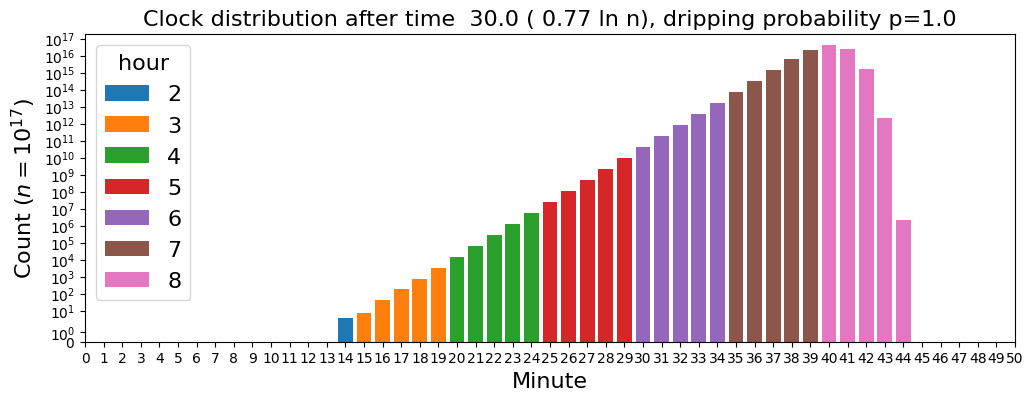

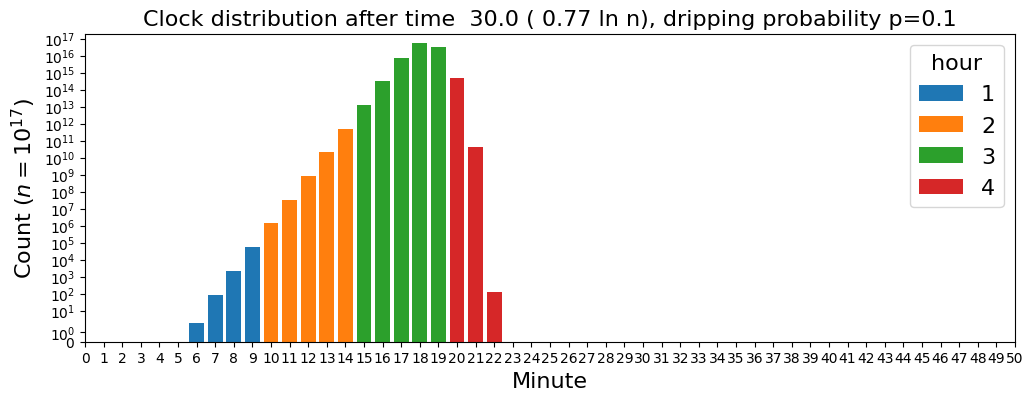

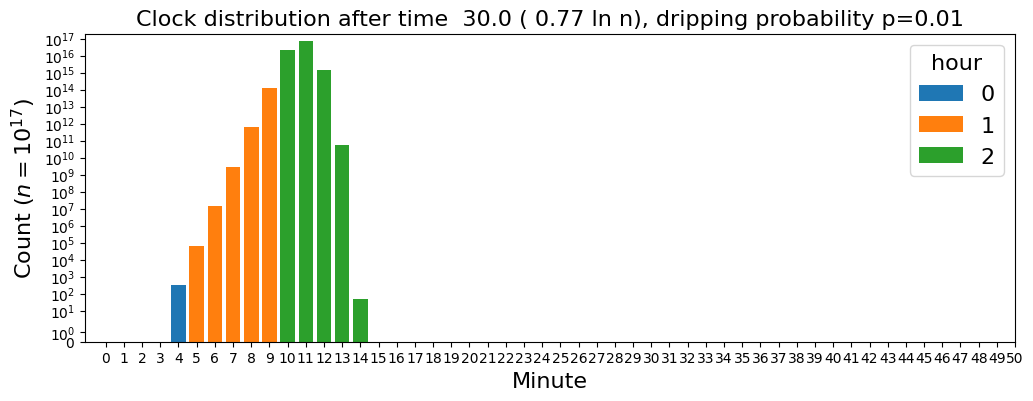

In [18]:
# This setup assumes non-interactive backend
# In an interactive backend, it will quickly and unnecessarily generate many figures
def plot_config(index):
    fig, ax = plt.subplots(figsize=(12,4))
    for i in range(m // k + 1):
        if sum(sim.history.iloc[index][i * k: min((i+1) * k, m+1)]):
            ax.bar(range(i * k, min((i+1) * k, m+1)), sim.history.iloc[index][i * k: (i+1) * k], label=str(i))
    ax.set_xticks(range(m+1))
    ax.set_xticklabels([str(i) for i in range(m+1)], fontsize = 10)
    ax.set_xlabel('Minute', fontsize=16)
    ax.set_ylabel('Count ($n=10^{' + str(int(np.log10(n))) + '}$)', fontsize=16)
    ax.set_yscale('symlog')
    ax.set_ylim(0, 2*n)
    ax.legend(title = 'hour', fontsize=16, title_fontsize=16)
    t = sim.times[index]
    ax.set_title(f'Clock distribution after time {t: 0.1f} ({t / np.log(n): 0.2f} ln n), dripping probability p={1/p}', fontsize=16)
#     fig.savefig('majority_simulations/clock_distribution.pdf')
    
# Number of minutes per hour for the plot
k = 5

# # Uncomment the following code to create a slider that changes the time shown in the plot
# p = 1
# p = 10
# p = 100
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

for p, index in [(1, 300),(10, 30),(100,30)]:
    sim = pickle.load( open( "majority_simulations/clock_p_"+ str(p) + ".p", "rb" ) )
    plot_config(index)
#     plt.savefig('majority_simulations/clock_distribution_p_' + str(p) + '.pdf')

The clock distribution gets tighter as the dripping probability $p$ decreases. The clock also runs slower. The following plot shows how the time per minute compares with $p$, and compares it to theoretical bounds. See the proofs in [the paper](https://arxiv.org/abs/2012.15800) for details.

In [19]:
## This code generated data on clock times and saved it to pickle

# def ten_perfect_past_threshold(config):
#     return sum([config[i] for i in range(threshold) if i in config]) <= 0.9 * n

# data = {'n': [], 'p': [], 'time': []}
# ps = np.geomspace(1, 10 ** 5, 11)
# for n in [10 ** 3, 10 ** 6, 10 ** 9]:
#     print(f'n = {n}')
#     for p in ps:
#         print(f'p = {p}')
#         for _ in range(10):
#             sim = Simulation({0: n}, clock, m = 20, p = 1/p)
#             threshold = 10
#             sim.run(ten_perfect_past_threshold, stopping_interval = 0.01, timer=False)
#             for h in range(11,21):
#                 t = sim.time
#                 threshold = h
#                 sim.run(ten_perfect_past_threshold, stopping_interval = 0.01, timer=False)
#                 data['time'].append(sim.time - t)
#                 data['p'].append(p)
#                 data['n'].append(n)

# pickle.dump(data, open( "majority_simulations/clock_times.p", "wb" ) )

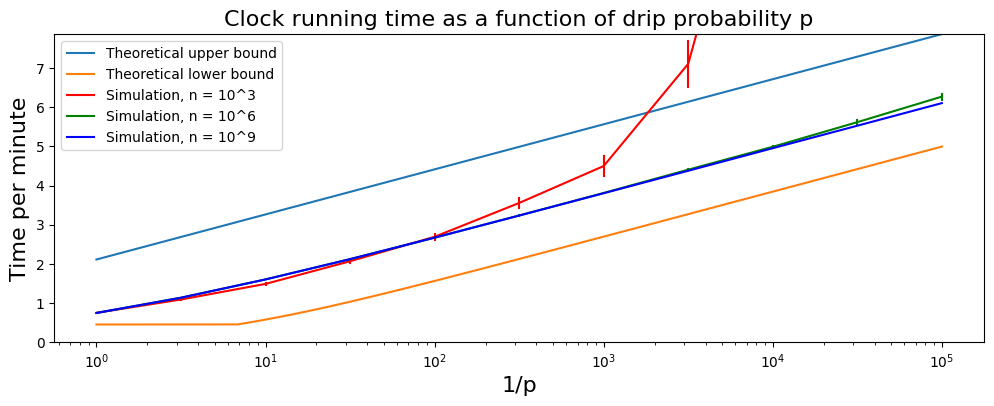

In [20]:
data = pickle.load( open( "majority_simulations/clock_times.p", "rb" ) )
ps = np.geomspace(1, 10 ** 5, 11)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(np.geomspace(1, 10 ** 5, 1000), 2.11+np.log(np.geomspace(1, 10 ** 5, 1000))/2)
ax.plot(np.geomspace(1, 10 ** 5, 1000), [max(np.log(1+2*p/9)/2 - 0.01, 0.45) for p in np.geomspace(1, 10 ** 5, 1000)])
sns.lineplot(data=data, x = 'p', y='time', hue='n', ax=ax, err_style='bars', palette=['red','green','blue'])
ax.set_xscale('log')
ax.set_ylim(0, 2.11+np.log(ps[-1])/2)
ax.set_xlabel('1/p', fontsize = 16)
ax.set_ylabel('Time per minute', fontsize = 16)
ax.legend(['Theoretical upper bound', 'Theoretical lower bound'] + [f'Simulation, n = 10^{int(np.log10(n))}' for n in sorted(set(data['n']))])
ax.set_title('Clock running time as a function of drip probability p', fontsize = 16)
plt.show()

# Adding Synchronization

The unbiased agents will now have a field `hour`, and will wait until `hour = i` before doing a split down to `exponent = -i`.
They will synchronize their `hour` with separate clock agents who are keeping a timer through a field `minute`, where `hour = minute // m` for a parameter `m` which gives the number of minutes per hour.

In [21]:
# We subclass the original Agent class, adding additional fields required for synchronization

@dataclass(unsafe_hash=True)
class MajorityAgent(Agent):
    role: str = 'main'
    _hour: int = 0
    minute: int = 0
    finished: bool = False
    m: int = 5
        
    @property
    def hour(self):
        if self.role == 'clock':
            return self.minute // self.m
        else:
            return self._hour
        
    @hour.setter
    def hour(self, value):
        if self.role == 'main':
            self._hour = value
        # can't change hour for a clock agent
    
    def __str__(self):
        if self.bias != 0:
            return super().__str__()
        if self.role == 'clock':
            return 'c' + str(self.minute)
        else:
            return 'u' + str(self.hour)
    
def init_majority_agents(a, b, m):
    return {MajorityAgent(opinion = 1, m = m): a, MajorityAgent(opinion = -1, m = m): b}

The clock agents will count for an additional `L` minutes after the last hour ($O(\log n)$ time). Then they will send a signal `finished = True` that makes all agents stop (and move on to a later phase of the algorithm).

In [22]:
def majority(a, b, L, p=1):
    a.finished = b.finished = a.finished or b.finished
    if a.finished:
        a.minute = b.minute = 0
        a.hour = b.hour = 0
    else:
        if a.role == b.role == 'main':
            # cancel reaction
            if a.bias == -b.bias != 0:
                a.opinion = b.opinion = 0
                a.hour = b.hour = abs(a.exponent)
                a.exponent = b.exponent = 0
                # half the agents from first split become clock
                if a.hour == 0:
                    a.role = 'clock'

            # split reaction
            if a.bias == 0 and b.bias != 0 and a.hour > abs(b.exponent):
                a.opinion = b.opinion
                a.exponent = b.exponent = b.exponent - 1
                a.hour = b.hour = 0

            if b.bias == 0 and a.bias != 0 and b.hour > abs(a.exponent) :
                b.opinion = a.opinion
                b.exponent = a.exponent = a.exponent - 1
                a.hour = b.hour = 0

        # unbiased agents propagate max hour
        if a.bias == b.bias == 0:
            a.hour = b.hour = min(max(a.hour, b.hour), L)

        # clock minute uses new fixed resolution phase clock
        if a.role == b.role == 'clock':
            # drip reaction
            if a.minute == b.minute:
                a.minute += 1
#               Wait an additional L minutes after hour L before finishing
                if a.minute == a.m * L + L:
                    a.finished = True
                # dripping reaction happens with probability p
                return {(a,b): p}
            # epidemic reaction
            else:
                a.minute = b.minute = max(a.minute, b.minute)

If we set the parameter `p = 1/n`, then the clock will take $\Theta(\log n)$ time per minute. Then with high probability the entire population will stay synchronized at the same hour. In this case, we have an $O(\log^2 n)$ time majority algorithm, essentially the same as the standard 'canceling and doubling' protocols.

In [23]:
n = 10 ** 9
g = int(n ** (1/3))
## This code ran a simulation and saved it to pickle
# sim = Simulation(init_majority_agents((n+g) // 2, (n-g) // 2, m = 3), majority, L=int(np.log2(n)), p = 1/n)
# sim.run()
# pickle.dump(sim, open( "majority_simulations/full_sync.p", "wb" ) )

# # This will load results back from pickle
sim = pickle.load( open( "majority_simulations/full_sync.p", "rb" ) )

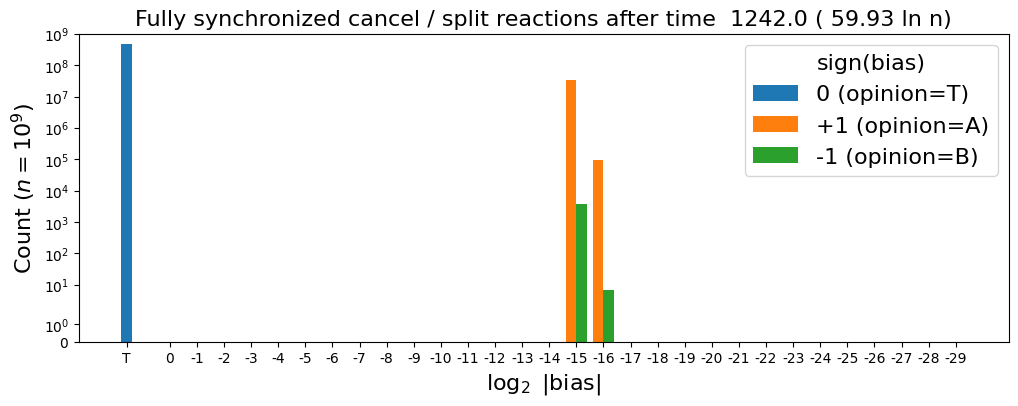

In [24]:
def plot_config(index):
    fig, ax = plt.subplots(figsize=(12,4))
    snap = sim.history.iloc[index]
    A_counts = snap.xs((1, False), level=('opinion', 'finished'))
    B_counts = snap.xs((-1, False), level=('opinion', 'finished'))
    ind = np.arange(len(A_counts))
    width = 0.4
    ax.bar(-1, sum(snap.xs((0, 'main'), level=('opinion', 'role'))), width, label='0 (opinion=T)')
    ax.bar(ind + width, A_counts, width, label= '+1 (opinion=A)')
    ax.bar(ind + 2 * width, B_counts, width, label= '-1 (opinion=B)')
    ax.set_xticks([-1] + list(ind+1.5*width))
    ax.set_xticklabels(['T'] + [str(i) for i in range(0,-len(A_counts),-1)], fontsize = 10)
    ax.set_xlabel('$\log_2$ |bias|', fontsize=16)
    ax.set_ylabel('Count ($n=10^9$)', fontsize=16)
    ax.set_yscale('symlog')
    ax.set_ylim(0, n)
    ax.legend(title = 'sign(bias)', fontsize=16, title_fontsize=16)
    t = sim.times[index]
    ax.set_title(f'Fully synchronized cancel / split reactions after time {t: 0.1f} ({t / np.log(n): 0.2f} ln n)', fontsize=16)
#     fig.savefig('majority_simulations/cancel_split_full_sync.pdf')
    
# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(1242)

We now set `p=1`, still with `m=3` minutes per hour, we have $O(1)$ time per minute and per hour. Then this entire phase lasts $\Theta(\log n)$ time. 

Although we will no longer elimiante all minority agents, with high probability, a vast majority of agents will finish with the majority opinion, in a range of 3 consecutive exponents.

In [25]:
n = 10 ** 9
g = int(n ** (1/3))
## This code ran a simulation and saved it to pickle
# sim = Simulation(init_majority_agents((n+g) // 2, (n-g) // 2, m = 3), majority, L=int(np.log2(n)))
# sim.run()
# pickle.dump(sim, open( "majority_simulations/main_averaging.p", "wb" ) )

# # This will load results back from pickle
sim = pickle.load( open( "majority_simulations/main_averaging.p", "rb" ) )

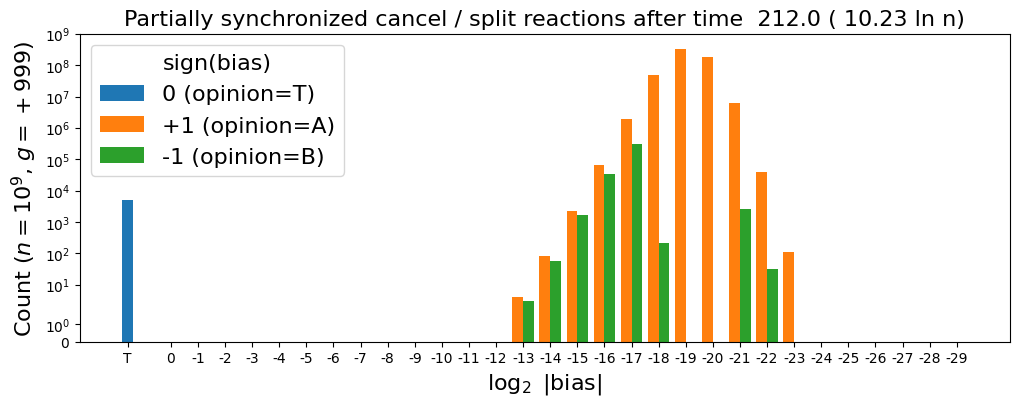

In [26]:
# This setup assumes non-interactive backend
# In an interactive backend, it will quickly and unnecessarily generate many figures
def plot_config(index):
    fig, ax = plt.subplots(figsize=(12,4))
    snap = sim.history.iloc[index]
    A_counts = snap.xs((1), level=('opinion')).groupby('exponent').sum()[::-1]
    B_counts = snap.xs((-1), level=('opinion')).groupby('exponent').sum()[::-1]
    ind = np.arange(len(A_counts))
    width = 0.4
    ax.bar(-1, sum(snap.xs((0, 'main'), level=('opinion', 'role'))), width, label='0 (opinion=T)')
    ax.bar(ind + width, A_counts, width, label= '+1 (opinion=A)')
    ax.bar(ind + 2 * width, B_counts, width, label= '-1 (opinion=B)')
    ax.set_xticks([-1] + list(ind+1.5*width))
    ax.set_xticklabels(['T'] + [str(i) for i in range(0,-len(A_counts),-1)], fontsize = 10)
    ax.set_xlabel('$\log_2$ |bias|', fontsize=16)
    ax.set_ylabel(f'Count ($n=10^{int(np.log10(n))}$, $g=+{g}$)', fontsize=16)
    ax.set_yscale('symlog')
    ax.set_ylim(0, n)
    ax.legend(title = 'sign(bias)', fontsize=16, title_fontsize=16)
    t = sim.times[index]
    ax.set_title(f'Partially synchronized cancel / split reactions after time {t: 0.1f} ({t / np.log(n): 0.2f} ln n)', fontsize=16)
#     fig.savefig('majority_simulations/main_averaging.pdf')
    
# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(212)


In the case of a tie, we will end up with every biased agent reaching the minimum value `exponent = -L`. Choosing $L = \lceil \log_2(n) \rceil$ ensures that this can only happen in the case of a tie. Thus we can check if all exponents are `-L` after this phase finishes to stably detect a tie.

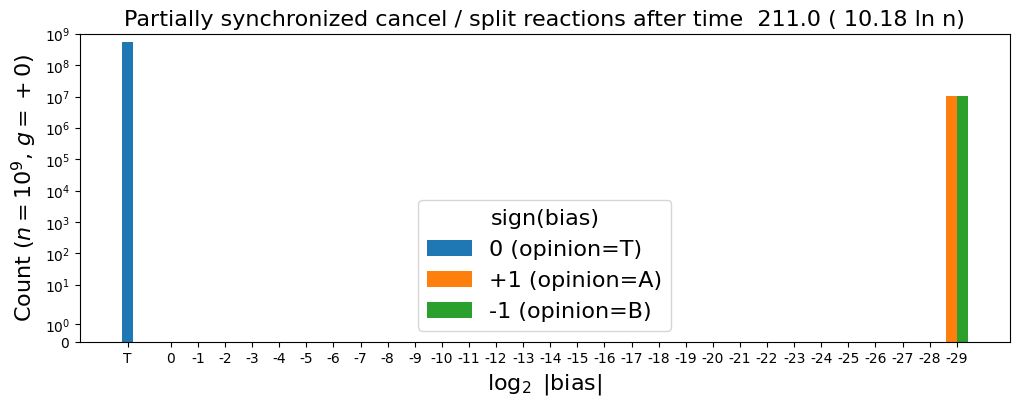

In [27]:
n = 10 ** 9
g = 0
## This code ran a simulation and saved it to pickle
# sim = Simulation(init_majority_agents((n+g) // 2, (n-g) // 2, m = 3), majority, L=int(np.log2(n)))
# sim.run()
# pickle.dump(sim, open( "majority_simulations/main_averaging_tie.p", "wb" ) )

# # This will load results back from pickle
sim = pickle.load( open( "majority_simulations/main_averaging_tie.p", "rb" ) )

# # Uncomment the following code to create a slider that changes the time shown in the plot
# bar = widgets.interact(plot_config, index = widgets.IntSlider(
#     min=0, max=len(sim.history)-1, step=1, value=0, layout = widgets.Layout(width='100%')))

plot_config(211)